### DSK Projekt "Projekt i implementacja algorytmu wyznaczającego optymalne struktury zgodnej z modelem PMC"

In [1]:
import numpy as np
import networkx as nx
import itertools
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
class MinimizerPMC:
    """Graph minimizer for PMC diagnose model"""
        
    def __init__(self, input_path):
        """
        Constructor loads data from the file and creates networkx digraph instance
        :param input_path: string
        """
        input_matrix = np.loadtxt(input_path)
        self.graph = nx.from_numpy_matrix(input_matrix, create_using=nx.DiGraph())
        
    def __check_diagnosability(self, graph, m):
        """
        Private method that checks m-diagnosability according to PMC model
        :param Graph: networkx.classes.digraph.DiGraph
        :param m: int
        :return: boolean
        """
        nodes = list(graph.nodes)
    
        # Checking necessary condition 1
        nes1 = True if len(graph) >= 2 * m + 1 else False 
        
        # Checking necessary condition 2
        nes2 = True
        for node in nodes:
            if graph.in_degree(node) < m:
                nes2 = False

        if nes1 and nes2:
            # Checking Hakimi, Amin conditions
            for s in range(m):
                subsets = list(itertools.combinations(nodes, len(graph) - 2 * m + s))
                for subset in subsets:
                    subset = list(subset)
                    edges = [np.array(list(graph.out_edges(node))).ravel().tolist() for node in subset]
                    merged_edges = list(itertools.chain(*edges))
                    gamma_nodes = list(set([node for node in merged_edges if node not in subset]))
                    if len(gamma_nodes) <= s:
                         return False
            return True

        else:
            return False
        
    def check_diagnosibility(self, m):
        """
        Checks diagnosability of input graph for given m
        :param m: int
        :return: boolean
        """
        return self.__check_diagnosability(self.graph, m)
    
    def minimize(self):
        # TODO
        pass
        
    
    def show_graph(self):
        """
        Displays graph with matplotlib library
        """
        graph_fixed_pos = nx.spring_layout(self.graph, seed=100)
        nx.draw(self.graph, pos=graph_fixed_pos, with_labels=True)
        plt.show()
        
    
    
    

### Struktura rzędu 5, jest 2-diagnozowalna

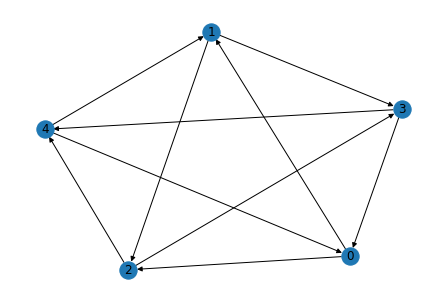

True

In [3]:
c = MinimizerPMC('Inputs/input_struct2.txt')
c.show_graph()
c.check_diagnosibility(2)

### Struktura rzędu 5, nie jest 2-diagnozowalna

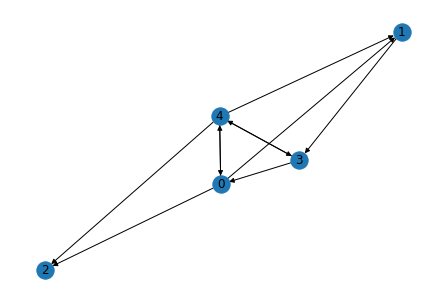

False

In [4]:
c = MinimizerPMC('Inputs/input_struct3.txt')
c.show_graph()
c.check_diagnosibility(2)

### Struktura rzędu 9, jest 4-diagnozowalna

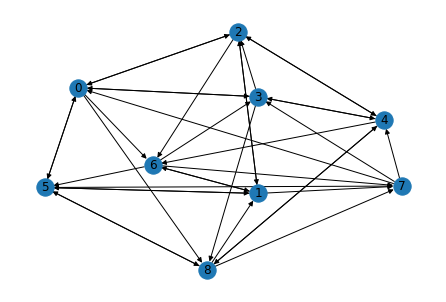

True

In [5]:
c = MinimizerPMC('Inputs/input_struct4.txt')
c.show_graph()
c.check_diagnosibility(4)

### Struktura rzędu 15, jest 5-diagnozowalna

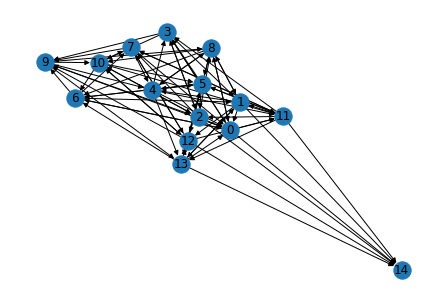

True

In [6]:
c = MinimizerPMC('Inputs/input_struct_large.txt')
c.show_graph()
c.check_diagnosibility(5)